In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [28]:
# Read and Preview the first few rows
df = pd.read_csv('russian_losses.csv')
df.head()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,...,submarines,personnel,personnel*,POW,daily_personnel,daily_tank,daily_APC,daily_field artillery,daily_vehicles and fuel tanks,day_ordinal
0,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,...,NaN,4300,about,0.0,1500.0,66.0,190.0,0.0,0.0,0
1,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,...,NaN,4500,about,0.0,200.0,4.0,0.0,1.0,0.0,1
2,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,...,NaN,5300,about,0.0,800.0,0.0,110.0,24.0,0.0,2
3,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,...,NaN,5710,about,200.0,410.0,48.0,30.0,3.0,0.0,3
4,2022-03-02,7,30,31,211,862,85,40,355.0,60.0,...,NaN,5840,about,200.0,130.0,13.0,16.0,8.0,0.0,4


In [29]:

# Read df
df = pd.read_csv('russian_losses.csv')

def load_and_process_data():
    # Convert date and sort
    df['date'] = pd.to_datetime(df['date'])
    df_sorted = df.sort_values('date')

    # Create a copy for Daily calculations (preserving Cumulative in 'df_sorted')
    # We define the columns we want to track
    cols_to_track = ['personnel', 'tank', 'APC', 'field artillery',
                     'vehicles and fuel tanks', 'drone', 'cruise missiles']

    # Handle missing values in cumulative data first
    df_sorted[cols_to_track] = df_sorted[cols_to_track].fillna(0)

    # Calculate Daily Losses (Difference from previous day)
    daily_df = df_sorted.copy()
    daily_df[cols_to_track] = df_sorted[cols_to_track].diff().fillna(0)

    # Filter out anomalies (negative values or unrealistic spikes)
    # E.g., removing days with < 0 losses (data correction artifacts)
    daily_df = daily_df[(daily_df[cols_to_track] >= 0).all(axis=1)]

    return df_sorted, daily_df




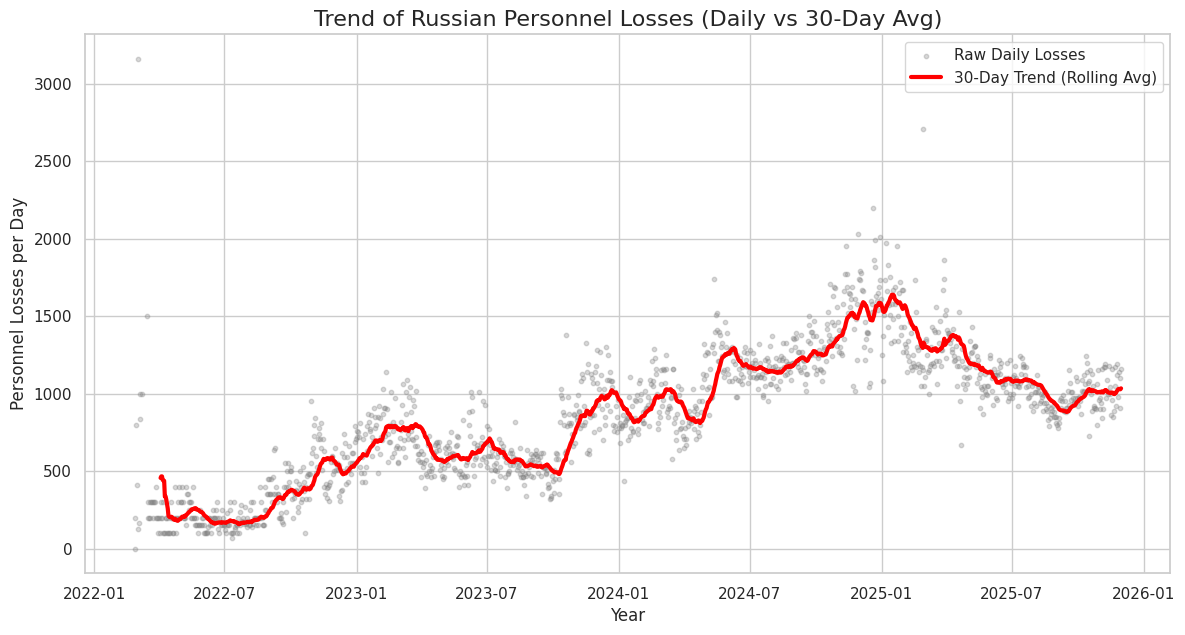

In [30]:

# Load the dataset
df = pd.read_csv('russian_losses.csv')

# Preprocessing: Convert date and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Calculate the true DAILY losses (Personnel is cumulative in the raw file)
# Compute the difference between consecutive days
df['daily_personnel'] = df['personnel'].diff().fillna(0)

# Filter out potential negative values (data correction artifacts)
df = df[df['daily_personnel'] >= 0].copy()

# Set date as index for easier time series analysis
df.set_index('date', inplace=True)
daily_losses = df['daily_personnel']

# Calculate 30-Day Rolling Average (Trend Lines)
rolling_avg = daily_losses.rolling(window=30).mean()

# Set plot style
sns.set_theme(style="whitegrid")

# Plot 1: Daily Personnel Losses with Trend Line
plt.figure(figsize=(14, 7))

# Plot raw daily dots (transparent)
plt.scatter(daily_losses.index, daily_losses, alpha=0.3, color='gray', label='Raw Daily Losses', s=10)

# Plot the 30-day trend line (bold)
plt.plot(rolling_avg.index, rolling_avg, color='red', linewidth=3, label='30-Day Trend (Rolling Avg)')

plt.title('Trend of Russian Personnel Losses (Daily vs 30-Day Avg)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Personnel Losses per Day')
plt.legend()
plt.savefig('daily_vs_30day_personnel_trend.png')
plt.show()

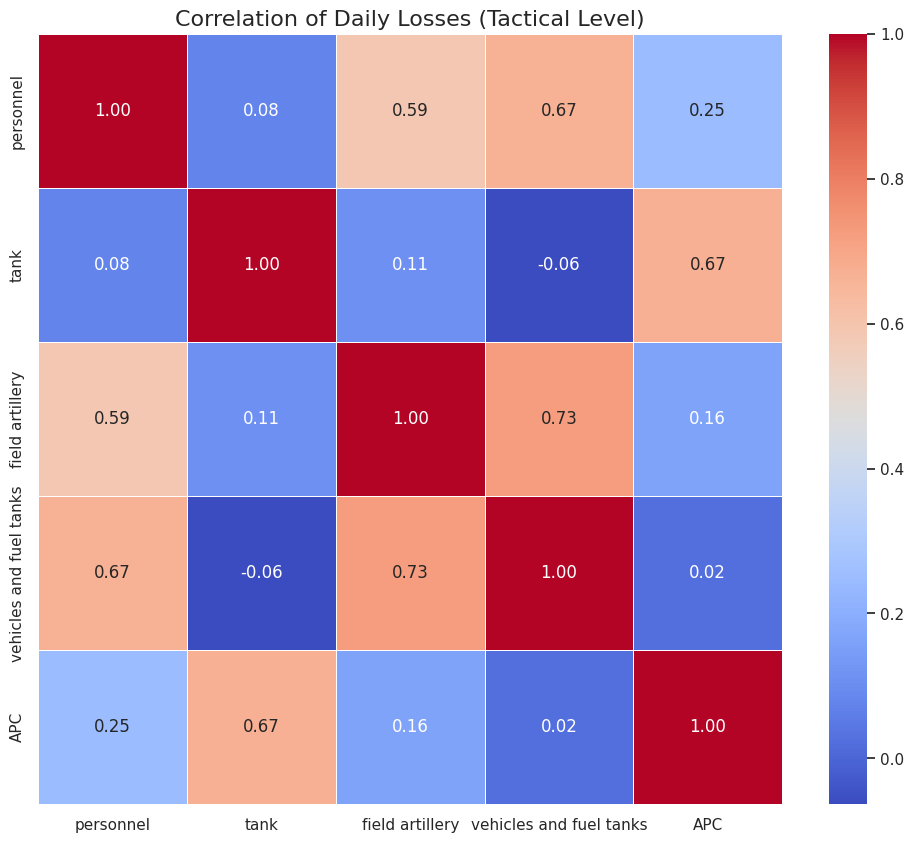

In [31]:
# Plot 2: Correlation Heatmap to analyse relationships


# 2. Select the columns you want to correlate
cols_to_analyze = ['personnel', 'tank', 'field artillery', 'vehicles and fuel tanks', 'APC']

# 3. Calculate DAILY changes for ALL selected columns
# The original dataset is cumulative, so we must .diff() everything
daily_losses_full = df[cols_to_analyze].diff().fillna(0)

# 5. Plot the Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = daily_losses_full.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation of Daily Losses (Tactical Level)', fontsize=16)
plt.show()

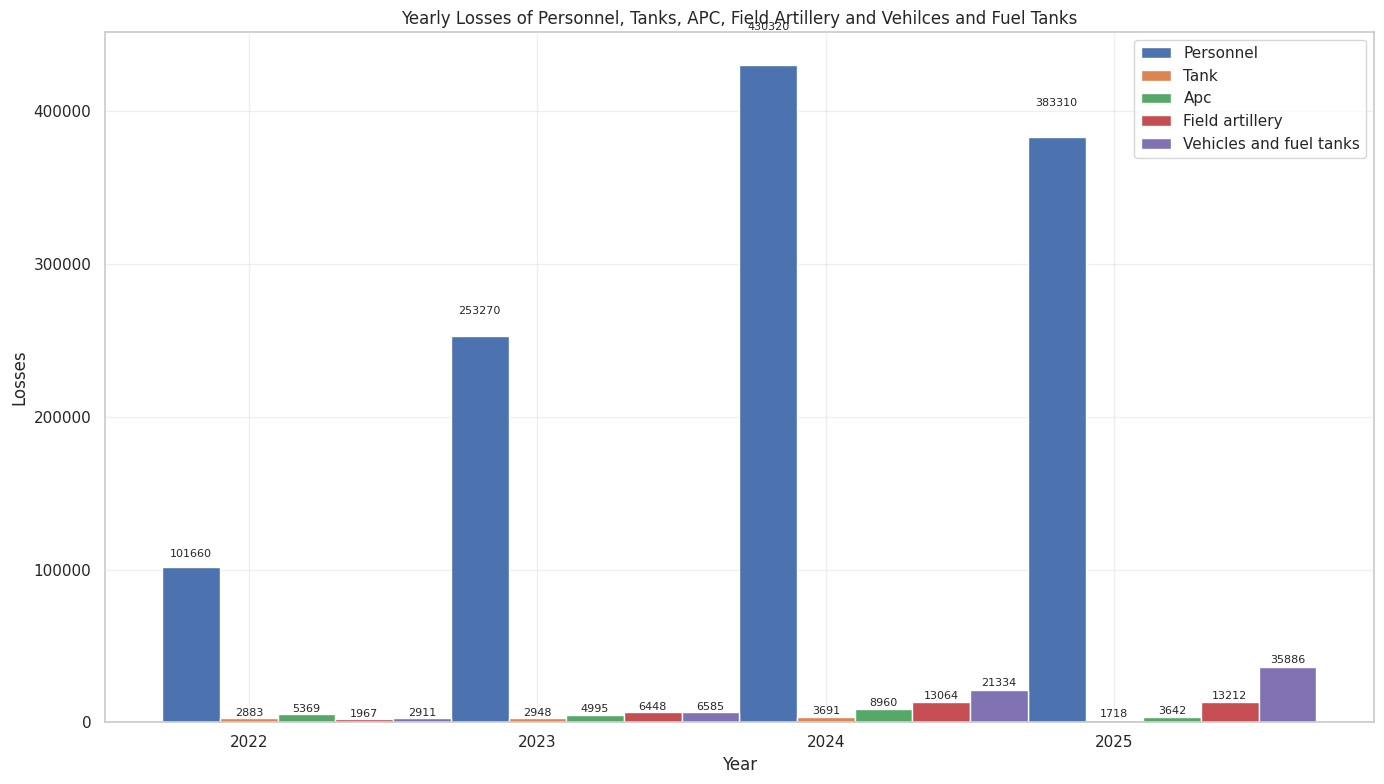

In [32]:
#Drawing a comparison among losses of personnel, tanks, APC, field artillery, vehicles and fuel tanks

df_original = pd.read_csv('russian_losses.csv')
df_losses = df_original[['date', 'personnel', 'tank', 'APC', 'field artillery', 'vehicles and fuel tanks']].copy()

# Convert date to datetime
df_losses['date'] = pd.to_datetime(df_losses['date'])

# Sort by date in ascending order to calculate daily increases correctly
df_losses = df_losses.sort_values('date', ascending=True)

# Calculate daily increases for each category
# The first row will be NaN after diff(), so fill with 0 as there's no prior day's loss
daily_increases = df_losses.set_index('date').diff().fillna(0)

# Reset index to make 'date' a column again
daily_increases = daily_increases.reset_index()

# Extract year from the date
daily_increases['year'] = daily_increases['date'].dt.year

# Group by year and sum the daily increases
yearly_df = daily_increases.groupby('year')[['personnel', 'tank', 'APC', 'field artillery', 'vehicles and fuel tanks']].sum().reset_index()

# Plot grouped bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.2
x = np.arange(len(yearly_df['year']))

# Plotting bars and adding labels
for i, col in enumerate(['personnel', 'tank', 'APC', 'field artillery', 'vehicles and fuel tanks']):
    bars = plt.bar(x + i*bar_width - bar_width, yearly_df[col], width=bar_width, label=col.capitalize())
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05 * yval, round(yval), ha='center', va='bottom', fontsize=8)

plt.xticks(x, yearly_df['year'])
plt.xlabel('Year')
plt.ylabel('Losses')
plt.title('Yearly Losses of Personnel, Tanks, APC, Field Artillery and Vehilces and Fuel Tanks')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

--- Step 1: Standard ARIMA Forecasts ---
  > Optimizing for personnel... Best Order: (2, 1, 2) (AIC: 17857.5)
  > Optimizing for tank... Best Order: (1, 1, 2) (AIC: 8842.8)
  > Optimizing for APC... Best Order: (1, 1, 1) (AIC: 10697.0)
  > Optimizing for field artillery... Best Order: (1, 1, 1) (AIC: 10580.3)
  > Optimizing for vehicles and fuel tanks... Best Order: (1, 1, 1) (AIC: 11997.0)


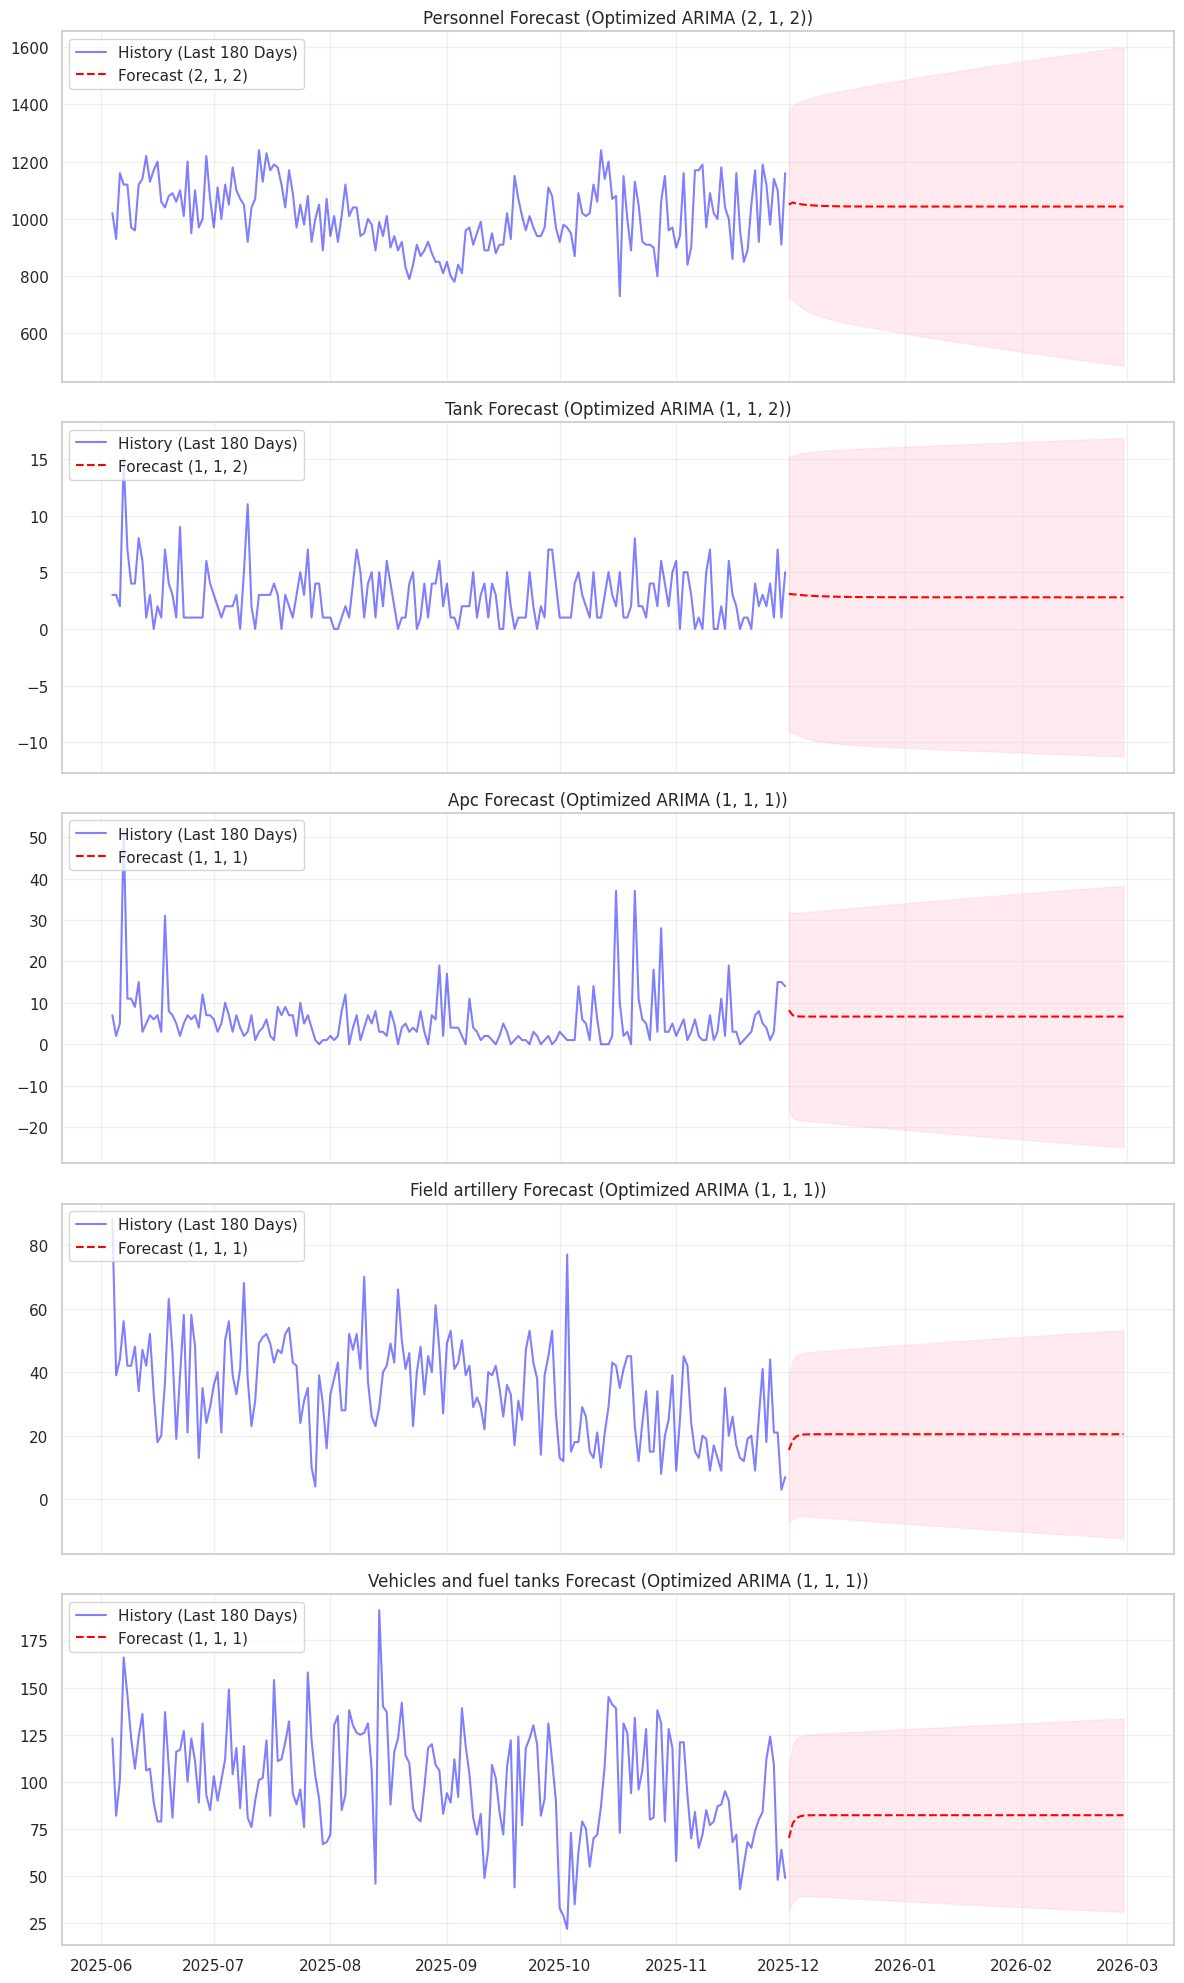


--- Step 2: ARIMAX (Personnel Forecast using Equipment as Input) ---
  > Optimizing for personnel... Best Order: (2, 1, 2) (AIC: 17857.5)


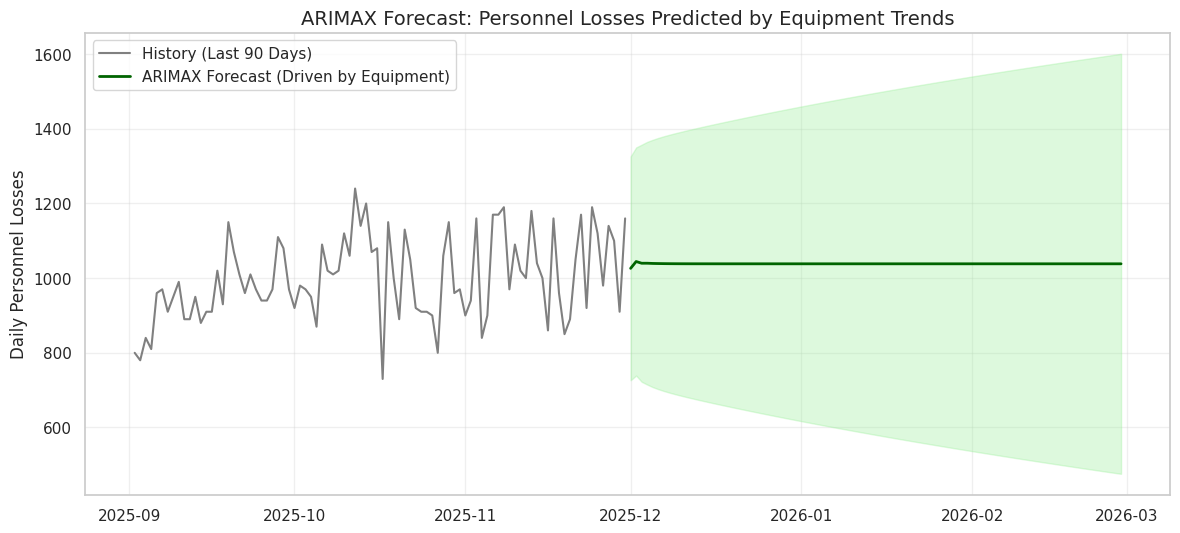

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings

# Predicting Personnel losses using ARIMA MODEL

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


# 1. LOAD & PREPROCESS

df = pd.read_csv("russian_losses.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Select columns
cols = ['personnel', 'tank', 'APC', 'field artillery', 'vehicles and fuel tanks']

# Compute Daily Losses
daily_df = pd.DataFrame()
daily_df['date'] = df['date']
for col in cols:
    daily_df[col] = df[col].diff().fillna(0)

daily_df.set_index('date', inplace=True)

# Clean anomalies (optional but good practice)
daily_df = daily_df[daily_df >= 0].dropna()


# 2. HELPER FUNCTION: FIND BEST ARIMA ORDER

def optimize_arima_order(series):
    """
    Performs a Grid Search to find the best (p,d,q) parameters
    based on the lowest AIC score.
    """
    # Define range of parameters to try
    # p = Auto-Regressive (past values), d = Differencing, q = Moving Average (past errors)
    p = range(0, 3)
    d = range(0, 2) # Since data is already diff(), d is likely 0 or 1
    q = range(0, 3)

    pdq_combinations = list(itertools.product(p, d, q))

    best_aic = float("inf")
    best_order = (1, 0, 1) # Default fallback

    print(f"  > Optimizing for {series.name}...", end=" ")

    for param in pdq_combinations:
        try:
            temp_model = ARIMA(series, order=param)
            results = temp_model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
        except:
            continue

    print(f"Best Order: {best_order} (AIC: {best_aic:.1f})")
    return best_order


# 3. FORECASTING LOOP (Standard ARIMA)

n_periods = 90
forecast_dates = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=n_periods)

fig, axes = plt.subplots(len(cols), 1, figsize=(12, 20), sharex=True)

print("--- Step 1: Standard ARIMA Forecasts ---")

for i, col in enumerate(cols):
    series = daily_df[col]

    # A. Find Optimal Order instead of hardcoding (1,1,1)
    best_order = optimize_arima_order(series)

    # B. Fit Model with Best Order
    model = ARIMA(series, order=best_order)
    model_fit = model.fit()

    # C. Forecast
    forecast_res = model_fit.get_forecast(steps=n_periods)
    forecast = forecast_res.predicted_mean
    conf_int = forecast_res.conf_int()

    # D. Plotting
    axes[i].plot(daily_df.index[-180:], series[-180:], color='blue', alpha=0.5, label=f'History (Last 180 Days)')
    axes[i].plot(forecast_dates, forecast, color='red', linestyle='--', label=f'Forecast {best_order}')
    axes[i].fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    axes[i].set_title(f'{col.capitalize()} Forecast (Optimized ARIMA {best_order})', fontsize=12)
    axes[i].legend(loc='upper left')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# 4. DEEP DIVE: ARIMAX (Exogenous Variables)

print("\n--- Step 2: ARIMAX (Personnel Forecast using Equipment as Input) ---")

# A. Prepare Exogenous Variables (The "X" in ARIMAX)
# We want to predict Personnel (y) using Tanks, APCs, Artillery (X)
exog_features = ['tank', 'APC', 'field artillery']
y_train = daily_df['personnel']
X_train = daily_df[exog_features]

# B. Create Future Exogenous Data
# To predict future Personnel, we need assumed values for future Equipment.
# We will use the "Scenario A" approach: Average of last 30 days.
future_exog = pd.DataFrame(index=forecast_dates, columns=exog_features)
for feature in exog_features:
    future_exog[feature] = daily_df[feature].tail(30).mean()

# C. Fit ARIMAX Model
# We pass the 'exog' parameter to the fit function
best_order_personnel = optimize_arima_order(y_train)
model_arimax = ARIMA(y_train, order=best_order_personnel, exog=X_train)
results_arimax = model_arimax.fit()

# D. Forecast with Exogenous Inputs
forecast_arimax = results_arimax.get_forecast(steps=n_periods, exog=future_exog)
pred_arimax = forecast_arimax.predicted_mean
conf_arimax = forecast_arimax.conf_int()

# E. Plot Comparison
plt.figure(figsize=(14, 6))
plt.plot(daily_df.index[-90:], daily_df['personnel'][-90:], label='History (Last 90 Days)', color='gray')
plt.plot(forecast_dates, pred_arimax, color='darkgreen', linewidth=2, label='ARIMAX Forecast (Driven by Equipment)')
plt.fill_between(forecast_dates, conf_arimax.iloc[:, 0], conf_arimax.iloc[:, 1], color='lightgreen', alpha=0.3)

plt.title('ARIMAX Forecast: Personnel Losses Predicted by Equipment Trends', fontsize=14)
plt.ylabel('Daily Personnel Losses')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [34]:


# Predicting Personnel losses for 2026 using LINEAR REGRESSION MODEL
#Personnel losses are predicted as against losses of APCs, field artillery, vehciles and fuel tanks and tanks
# Load dataset
df = pd.read_csv("russian_losses.csv")

# Preprocess
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 1. Compute daily increments (Explicitly naming columns)
df['daily_personnel'] = df['personnel'].diff().fillna(0)
df['daily_tanks'] = df['tank'].diff().fillna(0)
df['daily_APC'] = df['APC'].diff().fillna(0)
df['daily_field artillery'] = df['field artillery'].diff().fillna(0)
df['daily_vehicles and fuel tanks'] = df['vehicles and fuel tanks'].diff().fillna(0)

# 2. Filter valid rows
df = df[(df['daily_personnel'] > 0) &
        (df['daily_tanks'] >= 0) &
        (df['daily_APC'] >= 0) &
        (df['daily_vehicles and fuel tanks'] >= 0) &
        (df['daily_field artillery'] >= 0)]

# 3. Define Features and Target
features = ['daily_tanks', 'daily_field artillery', 'daily_APC', 'daily_vehicles and fuel tanks']
X = df[features]
y = df['daily_personnel']

# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5. Fit regression model
model = LinearRegression()
model.fit(X_train, y_train)


# WORKFLOW: PREDICT DAILY -> AGGREGATE MONTHLY


# A. Define the Scenario for 2026
recent_data = X_train.tail(90)
avg_daily_inputs = recent_data[features].mean()

# B. Create a Future DataFrame for 2026
dates_2026 = pd.date_range(start='2026-01-01', end='2026-12-31', freq='D')
future_df = pd.DataFrame(index=dates_2026)

for col in features:
    future_df[col] = avg_daily_inputs[col]

# C. Predict Daily Personnel Losses
future_df['predicted_daily_personnel'] = model.predict(future_df[features])

# D. Aggregating to Monthly Totals
monthly_totals = future_df.resample('M')['predicted_daily_personnel'].sum()

# Calculate Grand Total for 2026
total_predicted_loss_2026 = monthly_totals.sum()


# BOOTSTRAPPING (For Confidence Intervals)

n_bootstrap = 1000
bootstrap_totals = []

scenario_input = pd.DataFrame([avg_daily_inputs.values] * 365, columns=features)

for _ in range(n_bootstrap):
    X_res, y_res = resample(X_train, y_train)
    model_bs = LinearRegression().fit(X_res, y_res)
    daily_preds_bs = model_bs.predict(scenario_input)
    bootstrap_totals.append(daily_preds_bs.sum())

ci_lower = np.percentile(bootstrap_totals, 2.5)
ci_upper = np.percentile(bootstrap_totals, 97.5)


# VISUALIZATION

fig = go.Figure()

# Plot Monthly Totals (Line Chart)
fig.add_trace(go.Scatter(
    x=monthly_totals.index.strftime('%B'), # Month Names
    y=monthly_totals.values,
    mode='lines+markers', # Change to line + markers
    name='Monthly Forecast',
    line=dict(color='indianred', width=3),
    marker=dict(size=8)
))

# Add Average Line
fig.add_trace(go.Scatter(
    x=monthly_totals.index.strftime('%B'),
    y=[monthly_totals.mean()] * 12,
    mode='lines',
    line=dict(color='blue', dash='dash'),
    name='Avg Monthly Loss'
))

fig.update_layout(
    title=f"Projected Monthly Personnel Losses for 2026<br>Total Forecast: {total_predicted_loss_2026:,.0f} (95% CI: {ci_lower:,.0f} - {ci_upper:,.0f})",
    yaxis_title="Monthly Personnel Losses",
    xaxis_title="Month",
    template="plotly_white",
    showlegend=True
)

fig.show()

print(f"Predicted total loss for 2026: {total_predicted_loss_2026:,.0f}")
print(f"95% CI: [{ci_lower:,.0f}, {ci_upper:,.0f}]")

Predicted total loss for 2026: 494,554
95% CI: [476,324, 518,054]


Total Predicted Personnel Losses for 2026: 328473


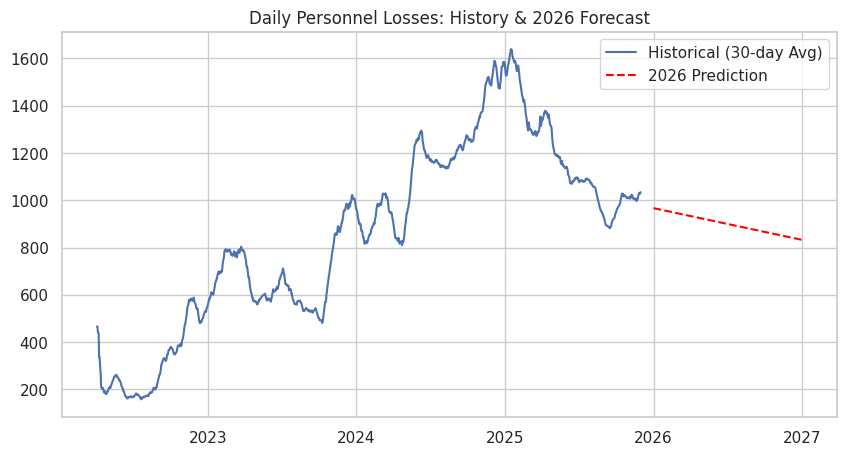

In [35]:


# Predicting Personnel losses based on LINEAR TREND

# We train the model only on recent data to capture current tactics
last_180_days = df.iloc[-180:].copy()
last_180_days['day_ordinal'] = (last_180_days['date'] - last_180_days['date'].min()).dt.days

# 4. Train Linear Trend Model
X = last_180_days[['day_ordinal']]
y = last_180_days['daily_personnel']

model = LinearRegression()
model.fit(X, y)

# 5. Predict for 2026
# Create a date range for the full year of 2026
future_dates = pd.date_range(start='2026-01-01', end='2026-12-31')
future_ordinal = (future_dates - last_180_days['date'].min()).days.values.reshape(-1, 1)

# Predict daily losses
future_daily_pred = model.predict(future_ordinal)

print(f"Total Predicted Personnel Losses for 2026: {int(future_daily_pred.sum())}")

# 6. Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['daily_personnel'].rolling(30).mean(), label='Historical (30-day Avg)')
plt.plot(future_dates, future_daily_pred, label='2026 Prediction', linestyle='--', color='red')
plt.title('Daily Personnel Losses: History & 2026 Forecast')
plt.legend()
plt.show()

In [36]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress ARIMA warnings for cleaner output
warnings.filterwarnings("ignore")


# 1. LOAD & PREPROCESS DATA

df = pd.read_csv("russian_losses.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Calculate Daily Increments (diff)
cols_to_diff = ['personnel', 'tank', 'APC', 'field artillery', 'vehicles and fuel tanks']
for col in cols_to_diff:
    df[f'daily_{col}'] = df[col].diff().fillna(0)

# Filter Anomalies (Negative values from corrections)
df = df[(df['daily_personnel'] > 0) & (df['daily_tank'] >= 0)]

# Define Features and Target
features = ['daily_tank', 'daily_APC', 'daily_field artillery', 'daily_vehicles and fuel tanks']
target = 'daily_personnel'


# 2. TRAIN THE "LINK" MODEL (Personnel ~ Equipment)

# This model learns: "If Russia loses 10 tanks, how many soldiers do they lose?"
X = df[features]
y = df[target]

link_model = LinearRegression()
link_model.fit(X, y)

print(f"Link Model Trained. Coefficient for Tanks: {link_model.coef_[0]:.2f}")


# 3. GENERATE EQUIPMENT SCENARIOS (The Inputs)

dates_2026 = pd.date_range(start='2026-01-01', end='2026-12-31', freq='D')

# Initialize DataFrames for the three scenarios
# They must have the EXACT same column names as 'features'
df_scenario_A = pd.DataFrame(index=dates_2026, columns=features) # Status Quo
df_scenario_B = pd.DataFrame(index=dates_2026, columns=features) # Linear Trend
df_scenario_C = pd.DataFrame(index=dates_2026, columns=features) # ARIMA Cycle

# Prepare data for Trend Analysis (Scenario B)
df['day_ordinal'] = (df['date'] - df['date'].min()).dt.days
future_ordinals = (dates_2026 - df['date'].min()).days.values.reshape(-1, 1)

print("\nGenerating Equipment Forecasts...")

for feature in features:
    # --- Scenario A: Status Quo (Last 90 Days Average) ---
    recent_avg = df[feature].tail(90).mean()
    df_scenario_A[feature] = recent_avg

    # --- Scenario B: Linear Trend (Projection) ---
    trend_reg = LinearRegression()
    trend_reg.fit(df[['day_ordinal']], df[feature])
    pred_trend = trend_reg.predict(future_ordinals)
    df_scenario_B[feature] = np.maximum(pred_trend, 0) # Clip at 0 (can't have negative losses)

    # --- Scenario C: ARIMA (Historical Cycles) ---
    # We use a simple (1,1,1) order
    arima_model = ARIMA(df[feature].values, order=(1,1,1)).fit()
    pred_arima = arima_model.forecast(steps=365)
    df_scenario_C[feature] = np.maximum(pred_arima, 0) # Clip at 0


# 4. PREDICT PERSONNEL LOSSES

# Now we feed the 3 equipment futures into the Link Model

# Predict Daily
pred_daily_A = link_model.predict(df_scenario_A)
pred_daily_B = link_model.predict(df_scenario_B)
pred_daily_C = link_model.predict(df_scenario_C)

# Store results in a master dataframe
results_df = pd.DataFrame(index=dates_2026)
results_df['Scenario A (Status Quo)'] = pred_daily_A
results_df['Scenario B (Linear Trend)'] = pred_daily_B
results_df['Scenario C (ARIMA Cycle)'] = pred_daily_C

# Resample to Monthly Totals
monthly_results = results_df.resample('M').sum()


# 5. VISUALIZATION

fig = go.Figure()

# Add Scenario A Line
fig.add_trace(go.Scatter(
    x=monthly_results.index.strftime('%B'),
    y=monthly_results['Scenario A (Status Quo)'],
    mode='lines+markers',
    name='Scenario A: Status Quo (90-Day Avg)',
    line=dict(color='gray', width=2, dash='dot')
))

# Add Scenario B Line
fig.add_trace(go.Scatter(
    x=monthly_results.index.strftime('%B'),
    y=monthly_results['Scenario B (Linear Trend)'],
    mode='lines+markers',
    name='Scenario B: Linear Trend',
    line=dict(color='blue', width=3)
))

# Add Scenario C Line
fig.add_trace(go.Scatter(
    x=monthly_results.index.strftime('%B'),
    y=monthly_results['Scenario C (ARIMA Cycle)'],
    mode='lines+markers',
    name='Scenario C: ARIMA Cycles',
    line=dict(color='red', width=3)
))

# Calculate Totals for Title
total_A = monthly_results['Scenario A (Status Quo)'].sum()
total_B = monthly_results['Scenario B (Linear Trend)'].sum()
total_C = monthly_results['Scenario C (ARIMA Cycle)'].sum()

fig.update_layout(
    title=f"2026 Personnel Loss Scenarios<br>Totals: Status Quo={total_A:,.0f} | Linear={total_B:,.0f} | ARIMA={total_C:,.0f}",
    yaxis_title="Monthly Personnel Losses",
    xaxis_title="Month",
    template="plotly_white",
    hovermode='x unified',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

# Print Analysis
print(f"\n=== 2026 Total Forecasts ===")
print(f"Scenario A (Status Quo): {total_A:,.0f}")
print(f"Scenario B (Linear Trend): {total_B:,.0f}")
print(f"Scenario C (ARIMA Cycle): {total_C:,.0f}")

Link Model Trained. Coefficient for Tanks: -5.27

Generating Equipment Forecasts...



=== 2026 Total Forecasts ===
Scenario A (Status Quo): 367,937
Scenario B (Linear Trend): 499,651
Scenario C (ARIMA Cycle): 348,730
